In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals

#! pip install tensorflow
# TensorFlow and tf.keras
import tensorflow as tf
#from tensorflow import keras

# import norm
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Helper libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
#import imageio as im

import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display


import os
from os import listdir
from os.path import isfile, join
import pickle
import random
#importing module
import sys
sys.path.insert(0, '../data')
from datahandler_multilabel import create_dataset

from PIL import ImageFile, Image

import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
with open('../data/train_test_split.pkl', 'rb') as infile:
    train_x, train_y, val_x, val_y, test_x, test_y = pickle.load(infile)

len(train_x), len(train_y), len(val_x), len(val_y), len(test_x), len(test_y)

(18000, 18000, 3000, 3000, 3999, 3999)

In [7]:
import keras
file = 'training_flat_multilabelVGG_weight.h5'
model = tf.keras.models.load_model('./results/'+file, compile=False,)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 15)                15375     
Total params: 15,255,375
Trainable params: 540,687
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

def mean_per_class_accuracy(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    per_class_acc = []
    per_class_acc.append(tf.cast(tf.math.count_nonzero(y_pred[i] * y[i], axis=0), tf.float32))
    mean_acc = tf.reduce_mean(per_class_acc)
    return mean_acc

def precision(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    pres = tp / (tp + fp + 1e-16)
    precision = tf.reduce_mean(pres)
    return precision

def recall(y, y_hat):
    y_pred = tf.cast(tf.greater(y_hat, 0.5), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    rec = tp / (tp + fn + 1e-16)
    recall = tf.reduce_mean(rec)
    return recall

In [9]:
adam = tf.keras.optimizers.Adam(name='Adam')
model.compile(optimizer= adam,
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["binary_accuracy",
                       "categorical_accuracy",
                       precision,
                       recall,
                       macro_f1
                      ])

In [65]:
train_generator = create_dataset(train_x, train_y)
val_generator = create_dataset(val_x, val_y)
test_generator = create_dataset(test_x, test_y)

In [11]:
model.evaluate(test_generator, verbose=2)

72/72 - 71s - loss: 0.3800 - binary_accuracy: 0.8485 - categorical_accuracy: 0.4381 - precision: 0.5832 - recall: 0.4338 - macro_f1: 0.4746


[0.38002346580227214, 0.8485288, 0.43810952, 0.583154, 0.4338497, 0.47460207]

In [7]:
pred = model.predict_generator(test_generator, verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
72/72 [==============================] - 65s 910ms/step


In [8]:
predicted_class_indices = np.where(pred > 0.5, 1, 0)
print(predicted_class_indices)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [9]:
def mean_per_class_accuracy(y, y_hat, num_classes):
    accuracy = [0]*num_classes
    for i in range(num_classes):
        accuracy[i] = 0
        for j in range(len(y)):
            if y[j][i] == y_hat[j][i]:
                accuracy[i] += 1
        accuracy[i] /= len(y)
    return accuracy

def mean_per_item_accuracy(y, y_hat, num_classes):
    accuracy = [0]*len(y)
    for i in range(len(y)):
        accuracy[i] = 0
        for j in range(num_classes):
            if y[i][j] == y_hat[i][j]:
                accuracy[i] += 1
        accuracy[i] /= num_classes
    return sum(accuracy)/len(y)


In [10]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices, 15
)
per_class_accuracy, sum(per_class_accuracy)/15

([0.498624656164041,
  0.5678919729932483,
  0.6114028507126782,
  0.5556389097274319,
  0.5743935983995999,
  0.6319079769942486,
  0.5023755938984746,
  0.6311577894473619,
  0.8929732433108277,
  0.7696924231057765,
  0.8767191797949487,
  0.9012253063265816,
  0.9022255563890973,
  0.9357339334833709,
  0.9034758689672419],
 0.7170292573143286)

In [11]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 15
)
per_item_accuracy

0.717029257314316

In [12]:
conf_matrix = multilabel_confusion_matrix(test_y, predicted_class_indices)
print(conf_matrix)

[[[ 806  940]
  [1065 1188]]

 [[1887  610]
  [1118  384]]

 [[2184  736]
  [ 818  261]]

 [[1846  820]
  [ 957  376]]

 [[1952  894]
  [ 808  345]]

 [[2306  487]
  [ 985  221]]

 [[1081  900]
  [1090  928]]

 [[2280  710]
  [ 765  244]]

 [[3557  164]
  [ 264   14]]

 [[3030  317]
  [ 604   48]]

 [[3496  122]
  [ 371   10]]

 [[3593   89]
  [ 306   11]]

 [[3606   44]
  [ 347    2]]

 [[3738   47]
  [ 210    4]]

 [[3604  112]
  [ 274    9]]]


In [13]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n', sum(precision)/15, '\n', sum(recall)/15, '\n', sum(f1)/15)

[0.55827068 0.38631791 0.26178536 0.31438127 0.27845036 0.31214689
 0.50765864 0.2557652  0.07865169 0.13150685 0.07575758 0.11
 0.04347826 0.07843137 0.07438017] 
 [0.52729694 0.25565912 0.24189064 0.28207052 0.29921943 0.18325041
 0.45986125 0.24182359 0.05035971 0.07361963 0.02624672 0.03470032
 0.00573066 0.01869159 0.03180212] 
 [0.54234193 0.30769231 0.25144509 0.29735073 0.28846154 0.23092999
 0.4825793  0.24859908 0.06140351 0.09439528 0.03898635 0.05275779
 0.01012658 0.03018868 0.04455446] 
 0.23113214790802095 
 0.18214817606975908 
 0.19878750838109777


In [14]:
import sklearn

In [15]:
sklearn.metrics.average_precision_score(test_y, predicted_class_indices, average='weighted')

0.34057016043374677

In [17]:
print(sklearn.metrics.classification_report(test_y, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.56      0.53      0.54      2253
           1       0.39      0.26      0.31      1502
           2       0.26      0.24      0.25      1079
           3       0.31      0.28      0.30      1333
           4       0.28      0.30      0.29      1153
           5       0.31      0.18      0.23      1206
           6       0.51      0.46      0.48      2018
           7       0.26      0.24      0.25      1009
           8       0.08      0.05      0.06       278
           9       0.13      0.07      0.09       652
          10       0.08      0.03      0.04       381
          11       0.11      0.03      0.05       317
          12       0.04      0.01      0.01       349
          13       0.08      0.02      0.03       214
          14       0.07      0.03      0.04       283

   micro avg       0.37      0.29      0.32     14027
   macro avg       0.23      0.18      0.20     14027
weighted avg       0.34   

c:\users\marco\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
labels_dict = {0:'people',1:'objects',2:'places',3:'architecture',4:'abstraction',5:'society',\
          6:'nature',7:'emotions, concepts and ideas',8:'interiors',9:'work and occupations', \
          10:'symbols & personifications',11:'religion and belief',12:'leisure and pastimes',\
          13:'history',14:'literature and fiction',15:'group/movement'}
predictions = [[]]*len(predicted_class_indices)
actual = [[]]*len(test_y)
for k in range(len(predicted_class_indices)):
    predictions[k] = []
    actual[k] = []
    for i in range(len(predicted_class_indices[k])):
        if predicted_class_indices[k][i] == 1:
            predictions[k].append(labels_dict[i])
        if test_y[k][i] == 1:
            actual[k].append(labels_dict[i])
            
print(len(predictions), len(actual))

3999 3999


In [68]:
results=pd.DataFrame({"Filename":test_x,
                      "Actual":actual,
                      "Predictions":predictions,
                      })
results.to_csv("./results/results"+file+".csv",index=False)

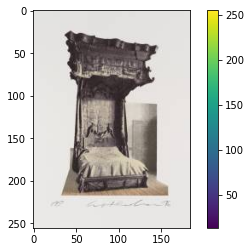

predicted as: ['abstraction', 'emotions, concepts and ideas'] 
actual class: ['objects', 'architecture', 'emotions, concepts and ideas', 'interiors', 'literature and fiction']


In [42]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results_Naive_VGG_weight.csv")
img  = Image.open(str(results.Filename[number]))
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

In [2]:
import torch
from CNN_RNN.model_attention import DecoderRNN
model = DecoderRNN(512, 1024, 19, 1).to('cpu')
checkpoint = torch.load('./results/decoder-5-600.ckpt', map_location=torch.device('cpu'))
print(checkpoint.keys())
model.load_state_dict(checkpoint)
model.eval()

odict_keys(['att_bias', 'embed.weight', 'lstm_cell.weight_ih', 'lstm_cell.weight_hh', 'lstm_cell.bias_ih', 'lstm_cell.bias_hh', 'linear.weight', 'linear.bias', 'att_vw.weight', 'att_hw.weight', 'att_w.weight'])


DecoderRNN(
  (embed): Embedding(19, 512)
  (lstm_cell): LSTMCell(1024, 1024)
  (linear): Linear(in_features=1024, out_features=19, bias=True)
  (att_vw): Linear(in_features=512, out_features=512, bias=False)
  (att_hw): Linear(in_features=1024, out_features=512, bias=False)
  (att_w): Linear(in_features=512, out_features=1, bias=False)
)

In [ ]:
import pickle
import numpy as np

with open('./results/predictions_CNN_RNN__.pkl', 'rb') as infile:
    predictions = pickle.load(infile)
reals = []
predicted = []
for key in predictions.keys():
    reals.append(predictions[key][1][0])
    preds = []
    for i in range(len(predictions[key][0][0])):
        preds += [np.argmax(predictions[key][0][0][i])]
    predicted.append(preds)
    
len(predicted), len(reals)

In [ ]:
predicted_class_indices = []
test_y = []

for i in range(len(predicted)):
    predicted_class_indices.append([0]*15)
    test_y.append([0]*15)
    for j in range(len(predicted[i])):
        if predicted[i][j] > 2:
            predicted_class_indices[i][predicted[i][j]-4] = 1
        if reals[i][j] > 2:
            test_y[i][reals[i][j]-4] = 1

predicted_class_indices[:10], test_y[:10]

In [164]:
from sklearn import metrics
precision = metrics.precision_score(test_y, predicted_class_indices, average=None)
recall = metrics.recall_score(test_y, predicted_class_indices, average=None)
f1 = metrics.f1_score(test_y, predicted_class_indices, average=None)
print(precision, '\n', recall, '\n', f1, '\n\n', sum(precision)/15, '\n', sum(recall)/15, '\n', sum(f1)/17)

[0.6525603  0.16666667 0.36785714 0.44106464 0.42528736 0.77667984
 0.57142857 0.5256167  0.43386243 0.72907489 0.39583333 0.16666667
 0.375      0.33187135 0.        ] 
 [0.91242604 0.09174312 0.40077821 0.34117647 0.27086384 0.49217282
 0.02380952 0.7630854  0.28671329 0.32104753 0.27142857 0.00420168
 0.09933775 0.71835443 0.        ] 
 [0.76091784 0.1183432  0.38361266 0.38474295 0.33094812 0.6025297
 0.04571429 0.62247191 0.34526316 0.44579125 0.3220339  0.00819672
 0.15706806 0.454      0.        ] 

 0.42396465931359173 
 0.33314257753377147 
 0.293037279836688


C:\Users\Ludovica\Anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
per_class_accuracy = mean_per_class_accuracy(
    test_y, predicted_class_indices
)
per_class_accuracy, sum(per_class_accuracy)/15

In [76]:
per_item_accuracy = mean_per_item_accuracy(
    test_y, predicted_class_indices, 15
)
per_item_accuracy

0.8229111111111028

In [43]:
print(metrics.classification_report(test_y, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.56      0.53      0.55      2253
           1       0.37      0.24      0.29      1502
           2       0.25      0.23      0.24      1079
           3       0.33      0.30      0.31      1333
           4       0.28      0.30      0.29      1153
           5       0.31      0.18      0.23      1206
           6       0.51      0.46      0.49      2018
           7       0.24      0.22      0.23      1009
           8       0.05      0.03      0.04       278
           9       0.17      0.09      0.12       652
          10       0.10      0.03      0.05       381
          11       0.14      0.04      0.07       317
          12       0.09      0.01      0.02       349
          13       0.08      0.02      0.03       214
          14       0.08      0.04      0.05       283

   micro avg       0.37      0.29      0.32     14027
   macro avg       0.24      0.18      0.20     14027
weighted avg       0.34   

c:\users\marco\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
number = random.randrange(0, 3000, 1)
img = Image.open('../../data_tate/'+ list(predictions.keys())[number])
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

import json
from CNN_RNN.build_vocab import Vocabulary


vocab = ['<pad>', '<start>', '<end>', '<unk>', 'people', 'religion and belief', 'emotions, concepts and ideas', 'work and occupations', 'society', 'nature', 'literature and fiction', 'objects', 'places', 'architecture', 'symbols & personifications', 'leisure and pastimes', 'interiors', 'abstraction', 'history']
print(vocab)   

print('actual class as:', [vocab[int(i)-1] for i in reals[number]],
      '\npredicted as:', [vocab[int(i)-1] for i in predicted[number]])

### Visualizing intermediate activations

In [54]:
layer_outputs = [layer.output for layer in model.get_layer("vgg16").layers] # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.get_layer("vgg16").get_layer("input_1").input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

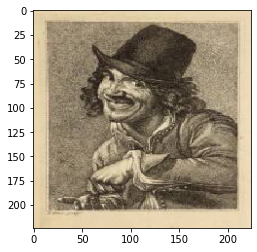

(1, 224, 224, 3)
predicted as: ['people', 'objects', 'emotions, concepts and ideas'] 
actual class: ['people', 'objects']


In [95]:
number = random.randrange(0, 4000, 1)
results = pd.read_csv("./results/results_Naive_VGG_weight.csv")
#img_path = test_x[number].replace("\\", '/')
img_path  = str(results.Filename[number])
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)
print('predicted as:', results.Predictions[number],
     '\nactual class:', results.Actual[number])

In [96]:
activations = activation_model.predict(img_tensor) 

In [97]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 112, 112, 64)


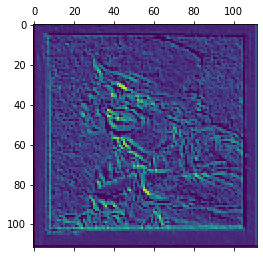

In [98]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')

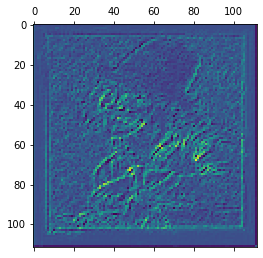

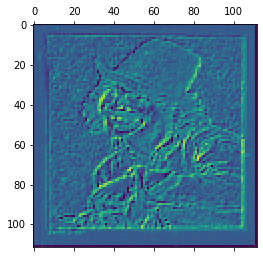

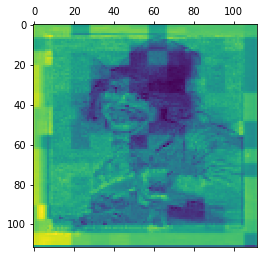

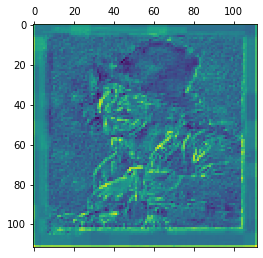

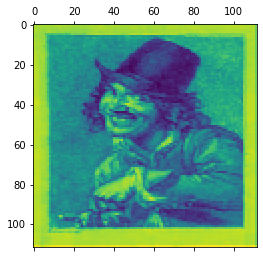

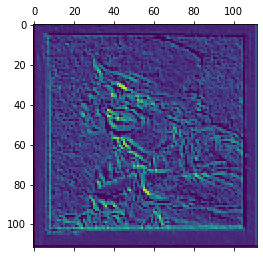

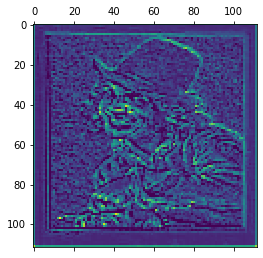

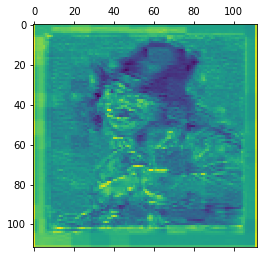

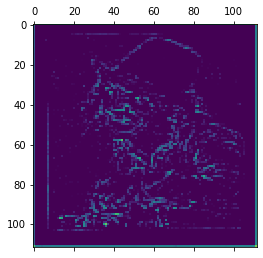

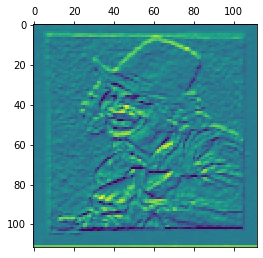

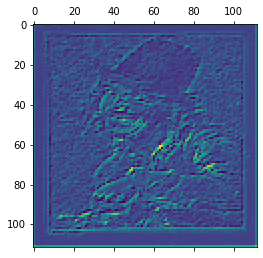

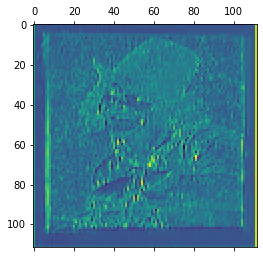

In [99]:
for i in range(12):
    plt.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [100]:
import matplotlib.pyplot as plt
from vis.visualization import visualize_saliency
from vis.utils import utils
from tensorflow.keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage

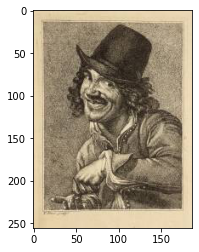

In [101]:
#img_path = test_x[number].replace("\\", '/')
img_path  = str(results.Filename[number])
img=mpimg.imread(img_path)
plt.imshow(img)

Saliency generate the saliency map that appears input regions that a change in the input value contribute the output value.

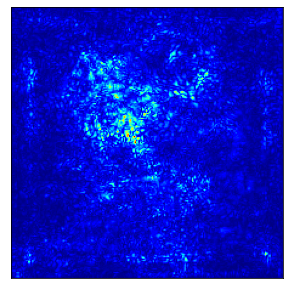

In [102]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

# Define modifier to replace a softmax function of the last layer to a linear function.
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

# Create Saliency object
saliency = Saliency(model, model_modifier)

loss= lambda output: K.mean(output)

img_path  = str(results.Filename[number])
img = image.load_img(img_path, target_size=(224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
# Generate saliency map
saliency_map = saliency(loss, img_tensor)
saliency_map = normalize(saliency_map)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
for i in range(len(saliency_map)):
    ax.imshow(saliency_map[i], cmap='jet')

Saliency is one of useful way of visualizing attention that appears input regions that a change in the input value contribute the output value. GradCAM is another way of visualizing attention over input. Instead of using gradients with respect to model outputs, it uses penultimate (pre Dense layer) Conv layer output.

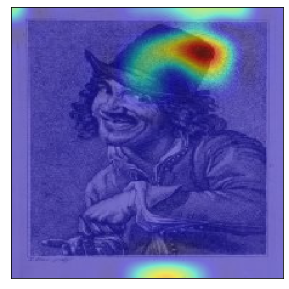

In [112]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

layer_outputs = [layer.output for layer in model.get_layer("vgg16").layers]  # Extracts the outputs of the top 12 layers
activation_model = tf.keras.models.Model(inputs=model.get_layer("vgg16").get_layer("input_1").input, outputs=layer_outputs) 

# Create Gradcam object
gradcam = Gradcam(activation_model, model_modifier)

cam = gradcam(loss, img_tensor)
cam = normalize(cam)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5),
                     subplot_kw={'xticks': [], 'yticks': []})
for i in range(len(cam)):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax.imshow(img)
    ax.imshow(heatmap, cmap='jet', alpha=0.5)

213
312
32
40
276
226
472
367
457
283
273
247
222
484
491
323


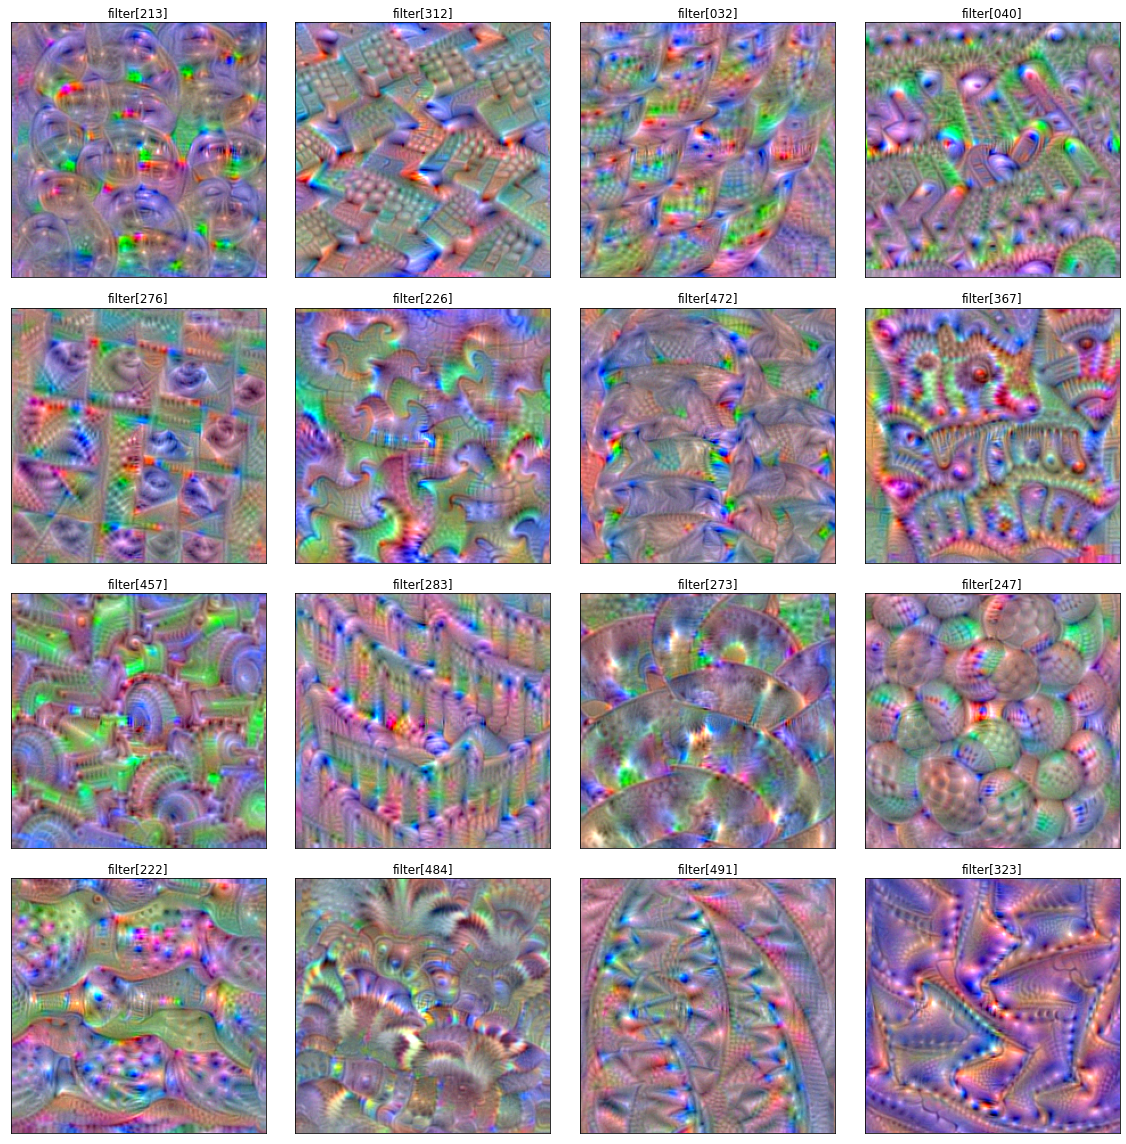

In [116]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.losses import SmoothedLoss

# The target layer that is the last layer of VGG16.
layer_name = 'block5_conv3'

# Define modifier to replace the model output to target layer's output.
# You need to return new model when you create new model instance in model_modifier.
def model_modifier(m):
    new_model = tf.keras.Model(inputs=m.inputs, outputs=[m.get_layer(name=layer_name).output])
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

# Create Activation Maximization object
activation_maximization = ActivationMaximization(activation_model, model_modifier)

num_of_filters = 16
filter_numbers = np.random.choice(activation_model.get_layer(name=layer_name).output.shape[-1], num_of_filters)
cols = 4
rows = num_of_filters // cols
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4), subplot_kw={'xticks': [], 'yticks': []})

for i, filter_number in enumerate(filter_numbers):
    print(filter_number)
    # Define loss function that is sum of a filter output.
    loss = SmoothedLoss(filter_number)

    # Generate max activation
    activation = activation_maximization(loss)
    img = activation[0].astype(np.uint8)
    ax[i // cols][i % cols].imshow(img)
    ax[i // cols][i % cols].set_title('filter[{:03d}]'.format(filter_number))

plt.tight_layout()
plt.show()

#### Results of evalute.py

In [2]:
with open('evals.pkl', 'rb') as infile:
    evals = pickle.load(infile)

evals.keys()

dict_keys(['training_flat_multilabel_ResNetfine_tuned.h5', 'training_flat_multilabel_VGGfine_tuned.h5', 'training_flat_multilabel_InceptionV3fine_tuned.h5', 'training_flat_multilabelVGG.h5', 'training_flat_multilabelInceptionV3.h5', 'training_flat_multilabelResNet.h5'])

### Plotting result records

In [153]:
list_paths = ['training_flat_multilabel_ResNetfine_tuned.csv', \
                  'training_flat_multilabel_VGGfine_tuned.csv', \
                  'training_flat_multilabel_InceptionV3fine_tuned.csv', \
                  'training_flat_multilabel_VGG.csv', \
                  'training_flat_multilabel_InceptionV3.csv', \
                  'training_flat_multilabel_ResNet.csv', \
                  'training_flat_multilabel_VGG_weight.csv', \
                 ]
record_model = {}
for record in list_paths:
    print(record)
    with open('./results/'+ record, 'rb') as infile:
        record_model[record] = pd.read_csv(infile)

training_flat_multilabel_ResNetfine_tuned.csv
training_flat_multilabel_VGGfine_tuned.csv
training_flat_multilabel_InceptionV3fine_tuned.csv
training_flat_multilabel_VGG.csv
training_flat_multilabel_InceptionV3.csv
training_flat_multilabel_ResNet.csv
training_flat_multilabel_VGG_weight.csv


In [154]:
record_model['training_flat_multilabel_VGG.csv']

epoch  binary_accuracy  categorical_accuracy      loss  macro_f1  \
0       0         0.819563              0.456611  0.410792  0.259689   
1       1         0.833811              0.464111  0.381774  0.319658   
2       2         0.837915              0.465944  0.371603  0.338579   
3       3         0.840311              0.467389  0.365092  0.348888   
4       4         0.843096              0.469889  0.360128  0.361182   
5       5         0.844085              0.473944  0.355648  0.371571   
6       6         0.846304              0.474611  0.351583  0.379031   
7       7         0.847971              0.475389  0.347790  0.388283   
8       8         0.849408              0.474944  0.344522  0.395312   
9       9         0.850618              0.479278  0.341875  0.403935   
10     10         0.852378              0.477389  0.337965  0.411512   
11     11         0.854229              0.483056  0.335475  0.417263   
12     12         0.854867              0.483500  0.332950  0.426987   
13     13         0.856582              0.485278  0.329769  0.435326   
14     14         0.857511              0.483944  0.327719  0.442029   
15     15         0.859185              0.483222  0.324104  0.448448   
16     16         0.859874              0.484000  0.322425  0.455640   
17     17         0.861478              0.489389  0.319095  0.463063   
18     18         0.863052              0.487000  0.315994  0.470419   
19     19         0.863707              0.491222  0.314444  0.471343   
20     20         0.864863              0.488056  0.311762  0.479434   
21     21         0.866722              0.490722  0.308809  0.491017   
22     22         0.867219              0.493222  0.306104  0.493488   
23     23         0.868563              0.491222  0.303864  0.501905   
24     24         0.870285              0.495111  0.301628  0.508099   
25     25         0.871177              0.494500  0.298708  0.512917   
26     26         0.872078              0.495222  0.296396  0.520538   
27     27         0.873437              0.500000  0.294015  0.522728   
28     28         0.874948              0.498111  0.291759  0.533297   
29     29         0.875981              0.499833  0.288982  0.534093   

    precision    recall  val_binary_accuracy  val_categorical_accuracy  \
0    0.344834  0.238409             0.834067                  0.452333   
1    0.426153  0.288185             0.839356                  0.468333   
2    0.447321  0.303668             0.840089                  0.463333   
3    0.455403  0.313748             0.839156                  0.520667   
4    0.477771  0.323602             0.843267                  0.476333   
5    0.487037  0.332350             0.843933                  0.445667   
6    0.498497  0.339537             0.845400                  0.463667   
7    0.514598  0.346656             0.845778                  0.475333   
8    0.522047  0.353234             0.845378                  0.474000   
9    0.536261  0.359703             0.847889                  0.479333   
10   0.541581  0.367352             0.848711                  0.482667   
11   0.549065  0.371944             0.845444                  0.474000   
12   0.567445  0.379108             0.848778                  0.474667   
13   0.576324  0.386769             0.848867                  0.478333   
14   0.582172  0.393973             0.850422                  0.484333   
15   0.590946  0.398851             0.849267                  0.469667   
16   0.599555  0.405755             0.850689                  0.484000   
17   0.607760  0.412530             0.850356                  0.497667   
18   0.616616  0.418309             0.849311                  0.462667   
19   0.615435  0.419733             0.849800                  0.496000   
20   0.624063  0.428485             0.852044                  0.511333   
21   0.642083  0.437033             0.850222                  0.500333   
22   0.643601  0.440218             0.850933                  0.49766

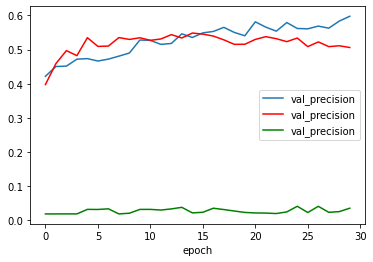

In [155]:
import matplotlib.pyplot as plt

# gca stands for 'get current axis'
ax = plt.gca()

record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_precision',ax=ax)
record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax)
record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax)

plt.show()

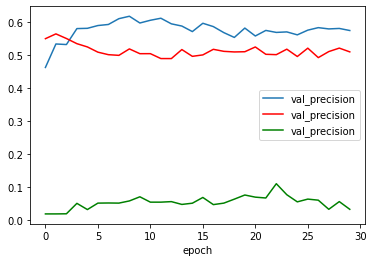

In [156]:
# gca stands for 'get current axis'
ax = plt.gca()

record_model['training_flat_multilabel_VGGfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision',ax=ax)
record_model['training_flat_multilabel_InceptionV3fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax)
record_model['training_flat_multilabel_ResNetfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax)

plt.show()

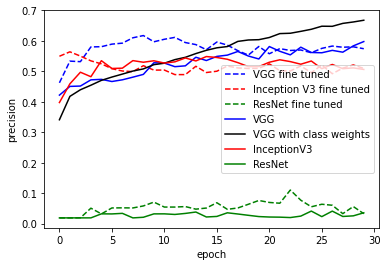

In [159]:
# gca stands for 'get current axis'
ax = plt.gca()
line1 = record_model['training_flat_multilabel_VGGfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='blue', style='--', ax=ax, label='VGG fine tuned')
line2 = record_model['training_flat_multilabel_InceptionV3fine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', style='--', ax=ax, label='Inception V3 fine tuned')
line3 = record_model['training_flat_multilabel_ResNetfine_tuned.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', style='--', ax=ax, label='ResNet fine tuned')
line4 = record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_precision', color='blue', ax=ax, label='VGG')
line4_ = record_model['training_flat_multilabel_VGG_weight.csv'][:30].plot(kind='line',x='epoch',y='precision', color='black', ax=ax, label='VGG with class weights')
line5 = record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_precision', color='red', ax=ax, label='InceptionV3')
line6 = record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_precision', color='green', ax=ax, label='ResNet')
plt.ylabel('precision')
plt.savefig('./results/precision_plot.png')
plt.show()

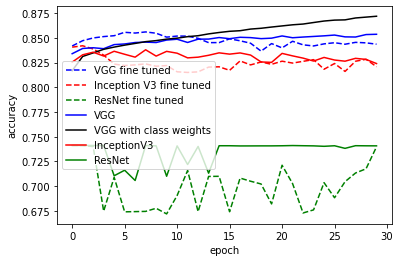

In [160]:
# gca stands for 'get current axis'
ax = plt.gca()
line1 = record_model['training_flat_multilabel_VGGfine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', style='--', ax=ax, label='VGG fine tuned')
line2 = record_model['training_flat_multilabel_InceptionV3fine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', style='--', ax=ax, label='Inception V3 fine tuned')
line3 = record_model['training_flat_multilabel_ResNetfine_tuned.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', style='--', ax=ax, label='ResNet fine tuned')
line4 = record_model['training_flat_multilabel_VGG.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='blue', ax=ax, label='VGG')
line4_ = record_model['training_flat_multilabel_VGG_weight.csv'][:30].plot(kind='line',x='epoch',y='binary_accuracy', color='black', ax=ax, label='VGG with class weights')
line5 = record_model['training_flat_multilabel_InceptionV3.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='red', ax=ax, label='InceptionV3')
line6 = record_model['training_flat_multilabel_ResNet.csv'].plot(kind='line',x='epoch',y='val_binary_accuracy', color='green', ax=ax, label='ResNet')
plt.ylabel('accuracy')
plt.savefig('./results/accuracy_plot.png')
plt.show()